# Process Baypass results

In [1]:
library(corrplot)
library(ape)
source("baypass_utils.R") 

corrplot 0.92 loaded

Warning message:
"package 'ape' was built under R version 4.1.3"


## Read in baypass results
Baypass was used with the command
```bash
baypass -gfile bft.kinrm.baypass -nthreads 20 -outprefix bft.thin -nval 10000 -burnin 10000 -pilotlength 1000
```
Columns in the input file correspond to these populations:
1. <- BRZ
2. <- BRZSP
3. <- KEY
4. <- MRT
5. <- PNS
6. <- PR
7. <- SCA
8. <- TX
9. <- VZ

In [2]:
bft.omega <- as.matrix(read.table("bft.thin_mat_omega.out"))

In [3]:
popnames <- c("BRZ", "BRZSP","KEY","MRT","PNS","PR","SCA","TX","VZ")

Identify pool names for, plotting

In [4]:
colnames(bft.omega) <- popnames
rownames(bft.omega) <- popnames

Create a correlation matrix of the omega values, which can be used to assess genomic differentiation between pools

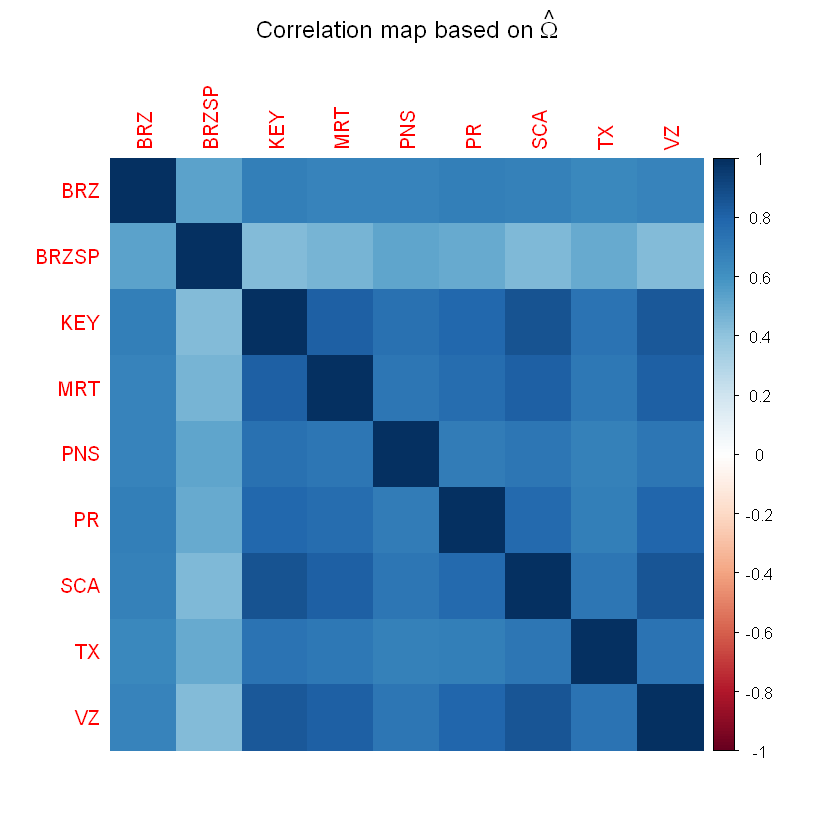

In [5]:
cor.mat <- cov2cor(bft.omega)
corrplot(
  cor.mat,method="color",mar=c(2,1,2,2)+0.1,
  main=expression("Correlation map based on"~hat(Omega))
)

Plot as hierarchical tree

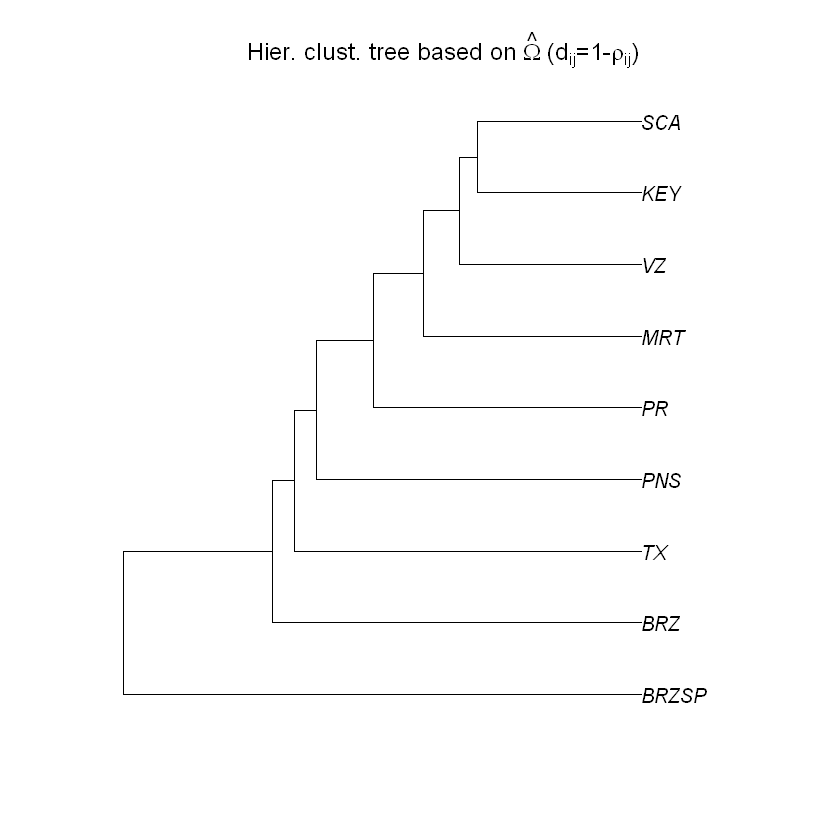

In [6]:
bft.tree <- as.phylo(hclust(as.dist(1-cor.mat**2)))
plot(
  bft.tree,type="p",
  main=expression("Hier. clust. tree based on"~hat(Omega)~"("*d[ij]*"=1-"*rho[ij]*")")
)

Read the xtx BayPass output

In [7]:
snp.res <- read.table("bft.thin_summary_pi_xtx.out", h=T)

Get the Pi Beta distribution for POD generation

In [8]:
pi.beta.coef <- read.table("bft.thin_summary_beta_params.out", h=T)$Mean

Upload original data to get read counts

In [10]:
bft.data <- geno2YN("../../data/bft.kinrm.baypass")

## Simulations

In [11]:
bft.sims <- simulate.baypass(
  omega.mat=bft.omega,nsnp=10000,sample.size=bft.data$NN,
  beta.pi=pi.beta.coef,pi.maf=0,suffix="bft.BP.sim"
)

Loading required package: mvtnorm



1000 SNP simulated out of 10000 
2000 SNP simulated out of 10000 
3000 SNP simulated out of 10000 
4000 SNP simulated out of 10000 
5000 SNP simulated out of 10000 
6000 SNP simulated out of 10000 
7000 SNP simulated out of 10000 
8000 SNP simulated out of 10000 
9000 SNP simulated out of 10000 
10000 SNP simulated out of 10000 


After using Baypass again on `bft.BP.sim`, import the results here
Simulations were analyzed with the command
```bash
baypass -gfile G.bft.BP.sim -nthreads 20 -outprefix bft.kinrm.sim -nval 10000 -burnin 10000 -pilotlength 1000
```

Read the new omega matrix and compare to original

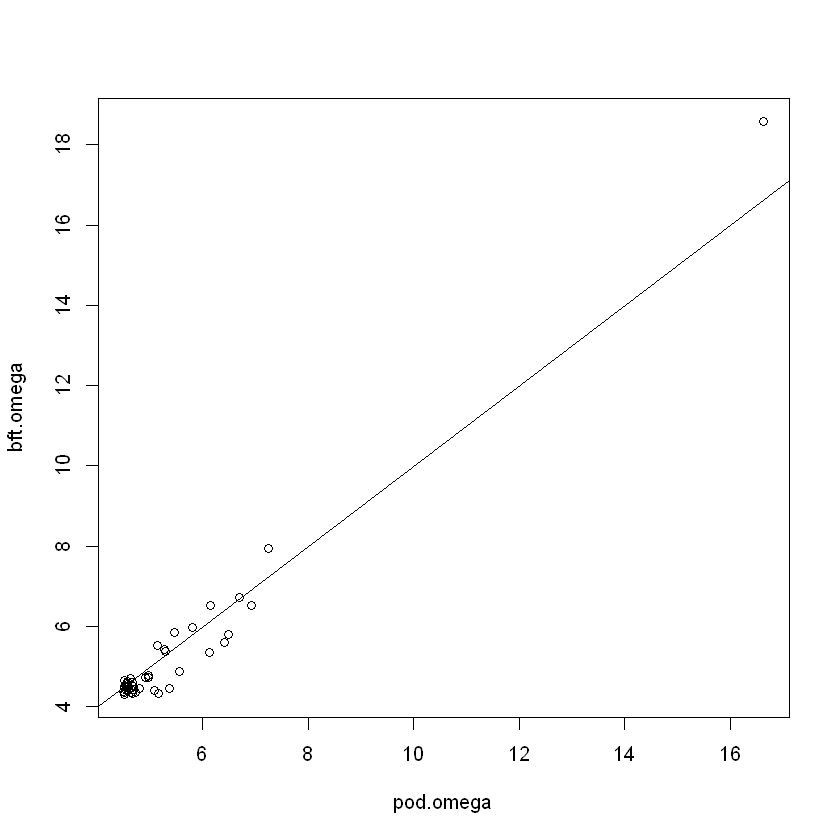

In [12]:
pod.omega <- as.matrix(read.table("bft.kinrm.sim_mat_omega.out"))
plot(pod.omega,bft.omega)
abline(a=0,b=1)

Get the Forstner and Moonen Distance (FMD) between simulated and original posterior estimates
- a smaller value is better

In [14]:
fmd.dist(pod.omega,bft.omega)

[1] 0.8555232

Look at POD xtx values, and identify SNPs where the xtx values are above the 99% significance threshold from the POD
- loci above the line are outliers

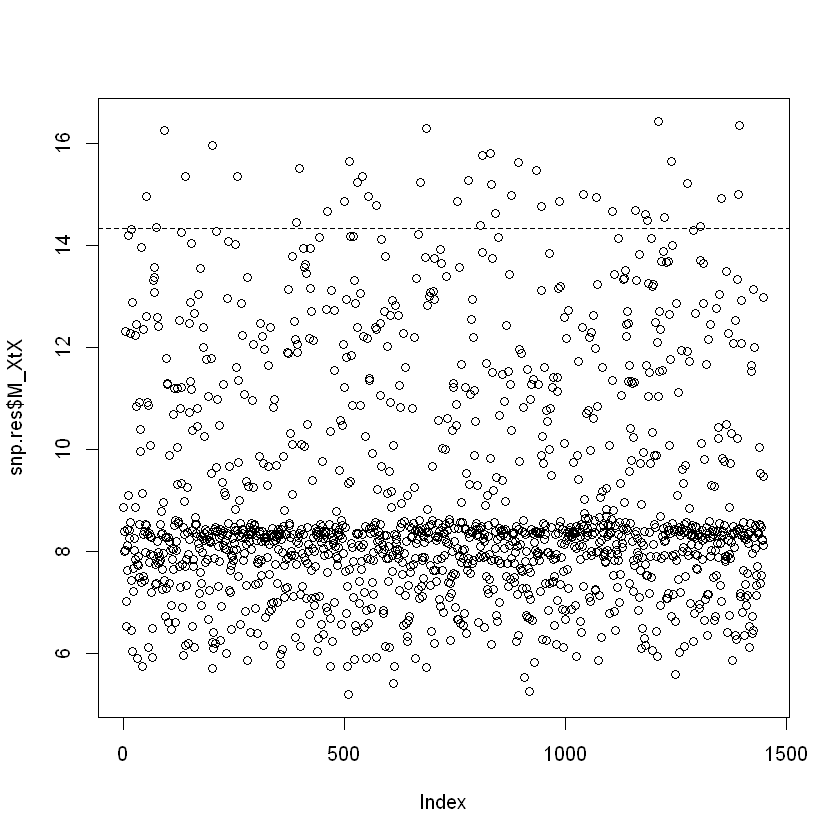

In [15]:
pod.xtx <- read.table("bft.kinrm.sim_summary_pi_xtx.out",h=T)$M_XtX
pod.thresh <- quantile(pod.xtx,probs=0.99)
plot(snp.res$M_XtX)
abline(h=pod.thresh,lty=2)

SNPs with an xtx value >`pod.thresh` are identified as outliers

In [16]:
snp.scores <- data.frame(snp_idx = 1:nrow(snp.res), M_XtX = snp.res$M_XtX, outlier = snp.res$M_XtX > pod.thresh)
head(snp.scores)

,snp_idx,M_XtX,outlier
,<int>,<dbl>,<lgl>
1,1,8.863086,FALSE
2,2,8.406213,FALSE
3,3,7.999224,FALSE
4,4,12.322319,FALSE
5,5,8.029559,FALSE
6,6,7.027755,FALSE


In [18]:
outliers <- snp.scores[snp.scores$outlier,1]
snp.names <- readLines("../../data/snp.names")
outlier.snps <- snp.names[outliers]
outlier.snps
length(outlier.snps)

[1] "11109_pilon_0_9627"  "15505_pilon_1182"    "17843_pilon_14110"  
 [4] "27601_pilon_14553"   "37918_pilon_5372"    "48400_pilon_59645"  
 [7] "71299_pilon_4998"    "72684_pilon_1115"    "81760_pilon_21713"  
[10] "88968_pilon_13757"   "90479_pilon_294"     "94230_pilon_23398"  
[13] "96091_pilon_11444"   "100040_pilon_3995"   "102827_pilon_7466"  
[16] "121264_pilon_6161"   "123135_pilon_1053"   "137993_pilon_19876" 
[19] "143934_pilon_248"    "147858_pilon_956"    "149609_pilon_959"   
[22] "153020_pilon_349"    "153512_pilon_132"    "154544_pilon_11063" 
[25] "161620_pilon_735"    "164644_pilon_6837"   "173398_pilon_0_7671"
[28] "174665_pilon_41371"  "184246_pilon_8558"   "198417_pilon_2344"  
[31] "204938_pilon_220"    "214603_pilon_405"    "229749_pilon_457"   
[34] "235691_pilon_9106"   "236078_pilon_4226"   "242520_pilon_3777"  
[37] "246002_pilon_2110"   "249802_pilon_1496"   "260302_pilon_2507"  
[40] "271143_pilon_2990"   "283882_pilon_10357"  "292870_pilon_1_817" 
[43] "293334_pilon_3311"

[1] 43

In [19]:
write.table(outlier.snps, file = "baypass.outliers.loci",row.names = F, col.names = F, quote = F)